<a href="https://colab.research.google.com/github/mssujith/2D_acoustic_FWI/blob/main/01-Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Well Log Analysis: SPWLA 2020 Petrophysical Data-Driven Analytics Contest

In 2020, [SWPLA](https://www.spwla.org/) (Society of Petrophysicists and Well Log Analysts) organized a contest to test the ability of machine-learning algorithms to analyze well-log information.

![](https://frontier-cf252.com/wp-content/uploads/oandg-large.jpg)

https://frontier-cf252.com/industries/well-logging/

## Background information

https://github.com/pddasig/Machine-Learning-Competition-2020

Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, such as gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, such as nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/Sonic_log.png/444px-Sonic_log.png)

https://en.wikipedia.org/wiki/Sonic_logging


[Sonic travel-time logs](https://wiki.seg.org/wiki/Dictionary:Sonic_log) contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is synthesizing them based on neighboring wells with sonic logs. This procedure is known as *sonic log synthesis* or pseudo sonic log generation.

## Download data

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=452e121abd1fa61fdbaf83c58a525eaadf9e7dfe5bd7845b69bd990e16cc0837
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
import wget

#download data
url = 'https://github.com/pddasig/Machine-Learning-Competition-2020/raw/master/Data3_1_2020.zip'
wget.download(url)

'Data3_1_2020.zip'

In [3]:
import zipfile

# Extract training data
with zipfile.ZipFile('Data3_1_2020.zip', 'r') as zipf:
    zipf.extract('train.csv')

The data is in the form of a CSV (comma-separated values) file. Different rows correspond to different depth levels in the borehole, and columns correspond to different logs.

We will use [pandas](https://pandas.pydata.org/), a Python data analysis library, for managing data.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Pandas_logo.svg/512px-Pandas_logo.svg.png)

In [4]:
import pandas as pd

In [5]:
# load data from the CSV file into a dataframe

logs = pd.read_csv('train.csv')
logs.head()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,-999.0,-999.0,41.4699,-999.0,-999.0,-999.0,-999.0,128.0737,319.0654
1,-999.0,-999.0,42.5053,-999.0,-999.0,-999.0,-999.0,127.8347,318.7825
2,-999.0,-999.0,43.1548,-999.0,-999.0,-999.0,-999.0,127.2307,317.3323
3,-999.0,-999.0,43.2410,-999.0,-999.0,-999.0,-999.0,126.2917,313.6486
4,-999.0,-999.0,40.3218,-999.0,-999.0,-999.0,-999.0,125.3985,307.8903


In [6]:
# data information
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     30143 non-null  float64
 1   CNC     30143 non-null  float64
 2   GR      30143 non-null  float64
 3   HRD     30143 non-null  float64
 4   HRM     30143 non-null  float64
 5   PE      30143 non-null  float64
 6   ZDEN    30143 non-null  float64
 7   DTC     30143 non-null  float64
 8   DTS     30143 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB


In [7]:
# data attributes
logs.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000,30143.000000
mean,-8.394576,-23.692615,38.959845,3.977690,1.547299,-17.446739,-20.229982,-54.891703,-9.737567
std,129.970219,157.142679,108.504554,365.112753,456.908969,149.083136,148.809506,372.858812,440.314119
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
25%,8.058350,0.122800,17.248750,0.717700,0.712050,0.053100,2.226700,66.304350,118.534350
50%,8.625000,0.193600,36.821800,1.623000,1.628100,4.941500,2.432200,78.355100,137.689300
75%,9.048850,0.337150,58.346150,3.158300,3.280600,7.856650,2.551350,107.022500,182.973150
max,21.064200,3490.158200,1470.253400,10000.000000,60467.761700,28.106400,3.259700,155.980300,487.438400


## Meaning of different columns

| Key | Description | Unit |
|-----|-------------|------|
| **CAL** | Caliper log | inch |
| **CNC** | Neutron log  | dec  |
| **GR**  | Gamma Ray log | API |
| **HRD** | Deep Resistivity log | Ohm per meter |
| **HRM** | Medium Resistivity log  | Ohm per meter |
| **PE**  | Photo-Electric Factor log | Barn |
| **ZDEN**| Density log | grams per cubic meter |
| **DTC** | Compressional Travel-time log | nanosecond per foot |
| **DTS** | Shear Travel-time log | nanosecond per foot |

Values set to -999 mark missing values.

The goal is to predict sonic logs (**DTC** and **DTS**) from the other logs.

Let us start by removing missing data.

In [8]:
import numpy as np
np.random.seed(2025)

# replace -999 with NaN
logs.replace(-999, np.nan, inplace=True)
# drop rows with NaN
logs.dropna(inplace=True)

In [9]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20525 entries, 573 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     20525 non-null  float64
 1   CNC     20525 non-null  float64
 2   GR      20525 non-null  float64
 3   HRD     20525 non-null  float64
 4   HRM     20525 non-null  float64
 5   PE      20525 non-null  float64
 6   ZDEN    20525 non-null  float64
 7   DTC     20525 non-null  float64
 8   DTS     20525 non-null  float64
dtypes: float64(9)
memory usage: 1.6 MB


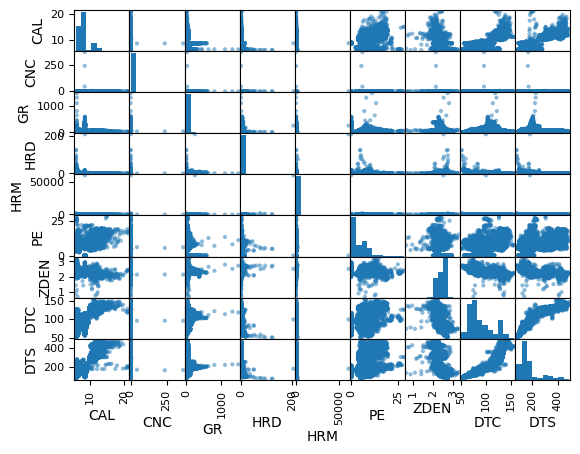

In [10]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# visualize cross-dependence of different data columns
scatter_matrix(logs)
plt.show()

## Attempt to predict sonic from density

We will start by selecting only two logs (**ZDEN** and **DTC**) and attempt to predict one from the other using a simple linear regression. The attempt may fail, but it will illustrate the general setup of the problem.

First, we will drop missing or anomalous values and examine the data distribution.

In [11]:
# select two logs
two = logs.loc[:, ('ZDEN', 'DTC')]
# data information
two.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20525 entries, 573 to 30142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    20525 non-null  float64
 1   DTC     20525 non-null  float64
dtypes: float64(2)
memory usage: 481.1 KB


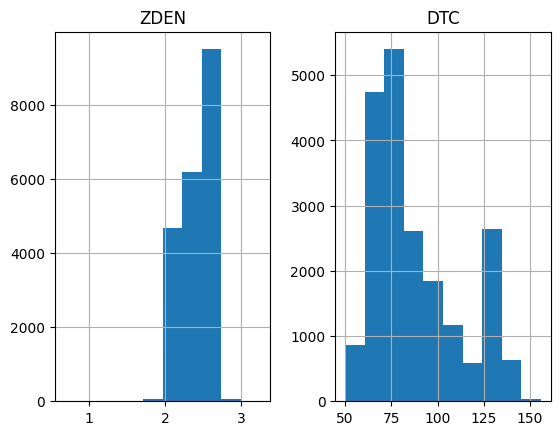

In [12]:
# display histogram
hist = two.hist()

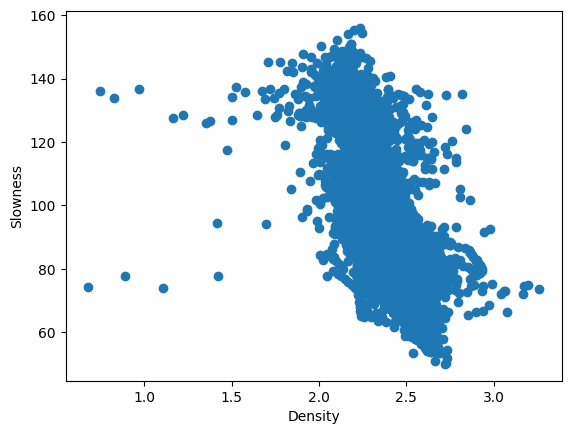

In [13]:
# display scatter plot

plt.scatter(two.ZDEN, two.DTC)
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

In [14]:
# remove anomalous density values
two2 = two.loc[(two.ZDEN > 1.5) & (two.ZDEN < 3.1)]
two2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20508 entries, 573 to 30142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    20508 non-null  float64
 1   DTC     20508 non-null  float64
dtypes: float64(2)
memory usage: 480.7 KB


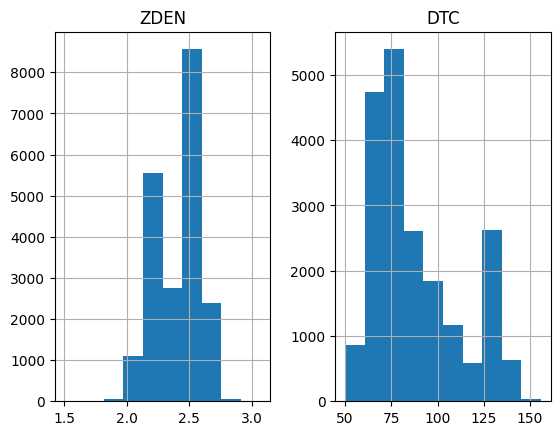

In [15]:
two2_hist = two2.hist()

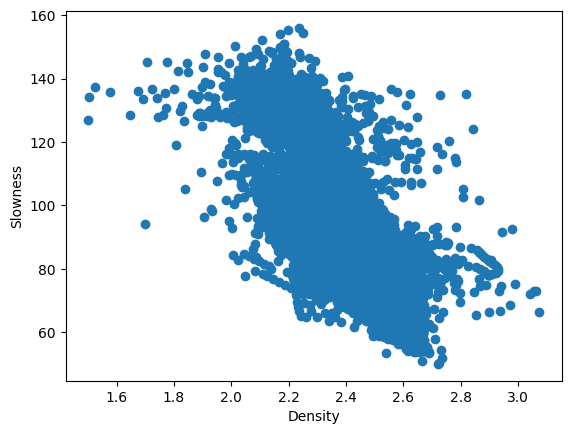

In [16]:
plt.scatter(two2.ZDEN, two2.DTC)
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

The dependence is complicated, but we can observe a general trend of slowness decreasing with density. Next, we will approximate this dependence with a straight line using *linear regression*, a classic statistical tool.

How do we know if our model works? We can divide the data into two parts: training and testing. We can then use the training part to fit the model and the testing part to validate the result. We will select 80% of the data for training and the remaining 20% for validation.

In [17]:
# divide into training and testing

# logical mask
select = np.random.rand(len(two2)) < 0.8
train = two2[select]
test = two2[~select]

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16421 entries, 573 to 30142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    16421 non-null  float64
 1   DTC     16421 non-null  float64
dtypes: float64(2)
memory usage: 384.9 KB


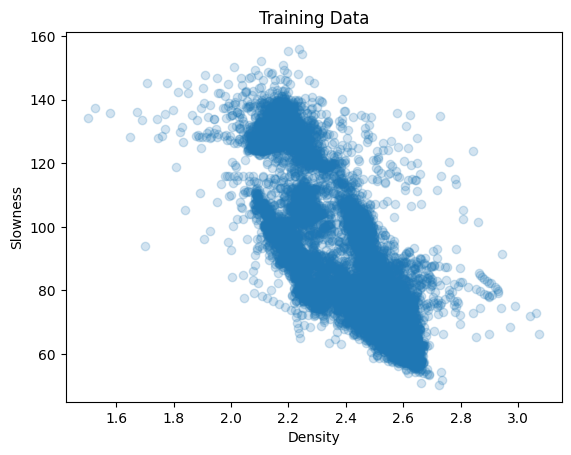

In [18]:
plt.scatter(train.ZDEN, train.DTC, alpha=0.2)
plt.title('Training Data')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

## Linear regression

Among other models, linear regression is provided by [scikit-learn](https://scikit-learn.org/), a package for classic machine learning algorithms.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/320px-Scikit_learn_logo_small.svg.png)

In [19]:
# create model
from sklearn import linear_model

model = linear_model.LinearRegression()

# train model
model.fit(train[['ZDEN']], train['DTC'])

LinearRegression()

Our first model has only two parameters: the intercept $a$ and the slope $b$ in the equation
$$s(\rho)=a+b\,\rho\;.$$
Fitting the model means estimating these parameters from the data.

In [20]:
# regression coefficients
print('Intercept: ', model.intercept_)
print('Coefficients: ', model.coef_)

Intercept:  347.3448070897368
Coefficients:  [-107.41563511]


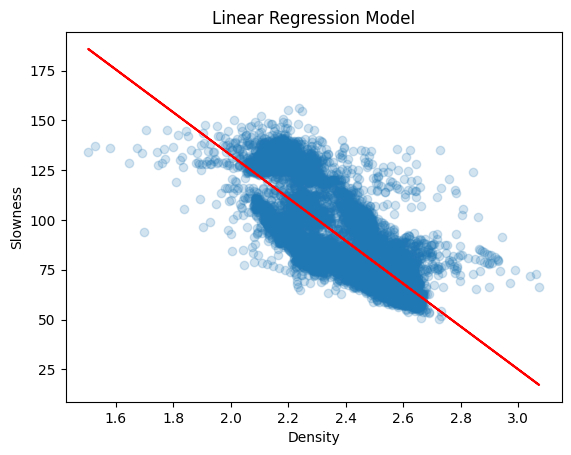

In [21]:
plt.scatter(train.ZDEN, train.DTC, alpha=0.2)
plt.plot(train.ZDEN, model.intercept_ +
        train.ZDEN * model.coef_[0], '-r')
plt.title('Linear Regression Model')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

Now, we can turn to the testing data and see how well our model predicts it.

There are different ways to measure the error. If $p_n$ are predicted values and $v_n$ are actual values, the classic linear regression uses the least-squares misfit

$\displaystyle \sum_{n=1}^{N} (p_n - v_n)^2\;.$

The root-mean-square error is defined as

$\displaystyle  \sqrt{\frac{1}{N} \sum_{n=1}^{N} (p_n - v_n)^2}\;.$

In [22]:
# evaluate prediction error
from sklearn.metrics import root_mean_squared_error

want = test['DTC']
get = model.predict(test[['ZDEN']])

print("RMS error: %.3f" % np.sqrt(np.mean((get - want)**2)))
print("RMS error: %.3f" % root_mean_squared_error(get, want))

RMS error: 13.887
RMS error: 13.887


In [23]:
root_mean_squared_error?

## How does it work?

The model parameters are estimated by minimizing the desired objective function. In the case of linear regression, the dependence on parameters is quadratic, and the minimum is found analytically. In the more general case, the minimization is achieved by some form of gradient descent.

In [24]:
def least_squares(a, b):
    d = train['ZDEN']
    s = train['DTC']
    return root_mean_squared_error(a+b*d, s)

a, b = np.meshgrid(
    np.linspace(start=-400, stop=1000, num=101),
    np.linspace(start=-400, stop=200,  num=101))
error = np.vectorize(least_squares)(a, b)

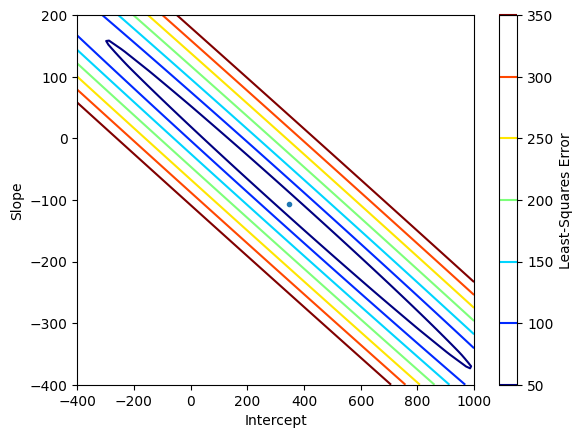

In [25]:
# plot surface
plt.contour(a, b, error, [50, 100, 150, 200, 250, 300, 350], cmap='jet')
plt.plot(model.intercept_, model.coef_[0], marker='.')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.colorbar(label='Least-Squares Error')
plt.show()

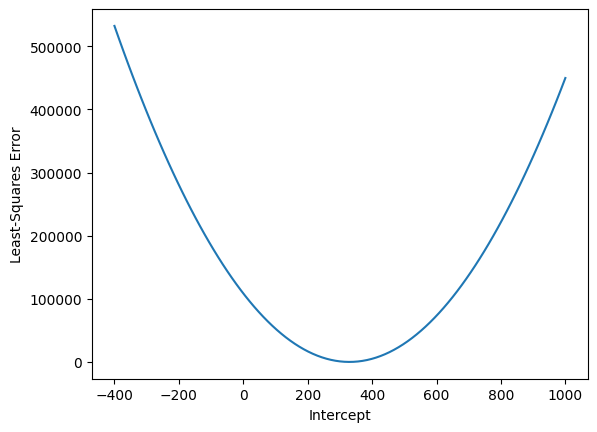

In [26]:
a = np.linspace(start=-400, stop=1000, num=101)
error = np.vectorize(least_squares)(a, -100)
plt.plot(a, error**2)
plt.xlabel('Intercept')
plt.ylabel('Least-Squares Error')
plt.show()

## How can we improve it?

One approach to complicate the dependence would be to extend the model, for example, from a line to a parabola.

In [27]:
# extend the model with density raised to degree 2
train = train.assign(ZDEN2=np.power(train.ZDEN, 2))
train.describe()

,ZDEN,DTC,ZDEN2
count,16421.000000,16421.000000,16421.000000
mean,2.411446,88.317841,5.846937
std,0.178518,23.551574,0.848531
min,1.503400,50.278700,2.260212
25%,2.236400,70.420600,5.001485
50%,2.467000,79.670100,6.086089
75%,2.563700,102.445300,6.572558
max,3.073500,155.980300,9.446402


In [28]:
# create model
model2 = linear_model.LinearRegression()

# train model
model2.fit(train[['ZDEN', 'ZDEN2']], train['DTC'])

LinearRegression()

In [29]:
# regression coefficients
print('Intercept: ', model2.intercept_)
print('Coefficients: ', model2.coef_)

Intercept:  566.1095685595054
Coefficients:  [-292.73059955   39.01396613]


The model changes from
$$s(\rho) = a + b\,\rho$$
to
$$s(\rho) = a + b_1\,\rho + b_2\,\rho^2$$

and involves three parameters ($a,b_1,b_2$) instead of two ($a,b$) as in the previous case.

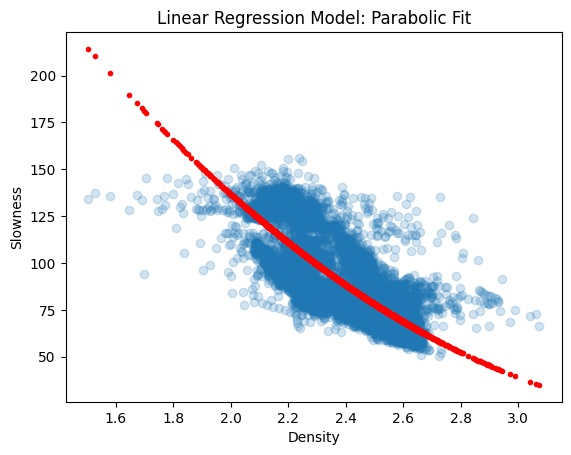

In [30]:
plt.scatter(train.ZDEN, train.DTC, alpha=0.2)
parabola = model2.intercept_ + \
      train.ZDEN  * model2.coef_[0] + \
      train.ZDEN2 * model2.coef_[1]
plt.plot(train.ZDEN, parabola, '.r')
plt.title('Linear Regression Model: Parabolic Fit')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

In [31]:
test = test.assign(ZDEN2=np.power(test.ZDEN, 2))

want = test['DTC']
get2 = model2.predict(test[['ZDEN', 'ZDEN2']])

print("RMS error: %.3f" % root_mean_squared_error(get2, want))

RMS error: 13.776


## Task 1

<div class="alert alert-block alert-info">
Can you improve the fit further by using a higher-degree polynomial?

$$s(\rho) = a_0 + b_1\,\rho + b_2\,\rho^2 + b_3\,\rho^3 + \cdots + b_N\,\rho^N$$

Choose $N \ge 3$ and add code to try it out.</div>

In [32]:
# extend the model with density raised to degree 3
train_task1 = train.assign(ZDEN3=np.power(train.ZDEN, 3))
train_task1['ZDEN4'] = np.power(train.ZDEN, 4)
train_task1['ZDEN5'] = np.power(train.ZDEN, 5)
# train_task3 = train.assign(ZDEN5=np.power(train.ZDEN, 5))

train_task1.describe()



,ZDEN,DTC,ZDEN2,ZDEN3,ZDEN4,ZDEN5
count,16421.000000,16421.000000,16421.000000,16421.000000,16421.000000,16421.000000
mean,2.411446,88.317841,5.846937,14.250938,34.906633,85.902198
std,0.178518,23.551574,0.848531,3.040145,9.729022,29.327922
min,1.503400,50.278700,2.260212,3.398002,5.108556,7.680204
25%,2.236400,70.420600,5.001485,11.185321,25.014852,55.943215
50%,2.467000,79.670100,6.086089,15.014382,37.040479,91.378862
75%,2.563700,102.445300,6.572558,16.850066,43.198515,110.748032
max,3.073500,155.980300,9.446402,29.033517,89.234515,274.262283


In [33]:
test_task1 = test.assign(ZDEN3=np.power(test.ZDEN, 3))
test_task1['ZDEN4'] = np.power(test.ZDEN, 4)
test_task1['ZDEN5'] = np.power(test.ZDEN, 5)

test_task1.describe()

,ZDEN,DTC,ZDEN2,ZDEN3,ZDEN4,ZDEN5
count,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,2.411186,88.234688,5.845525,14.245529,34.889135,85.851685
std,0.178083,23.478557,0.848026,3.044044,9.761254,29.492990
min,1.501600,49.970500,2.254803,3.385812,5.084135,7.634336
25%,2.235750,70.377150,4.998578,11.175571,24.985783,55.861964
50%,2.465200,79.782100,6.077211,14.981541,36.932494,91.045984
75%,2.563500,102.476400,6.571532,16.846123,43.185036,110.704840
max,3.055900,153.927100,9.338525,28.537598,87.208046,266.499067


In [34]:
['a', 'b'] + ['c']

['a', 'b', 'c']

In [35]:
var = ['ZDEN3', 'ZDEN4', 'ZDEN5']

want = test_task1['DTC']
for i in range(3):


    # create model
    model_task1 = linear_model.LinearRegression()
    var_i = var[:i]
    # var_i = test_task1[f'ZDEN{i}'] = np.power(test.ZDEN, i)
    # train model
    model_task1.fit(train_task1[['ZDEN', 'ZDEN2']+var_i], train_task1['DTC'])


    get2 = model_task1.predict(test_task1[['ZDEN', 'ZDEN2']+var_i])

    print("RMS error for %d: %.3f" % (i+3, root_mean_squared_error(get2, want)))

RMS error for 3: 13.776
RMS error for 4: 13.492
RMS error for 5: 13.491


## More inputs

Another way to extend the model is to involve other logs.

Let us try the Gamma-ray log in addition to the density log.

In [36]:
# select three logs
three = logs.loc[:, ['ZDEN', 'GR', 'DTC']]
# data information
three.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20525 entries, 573 to 30142
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    20525 non-null  float64
 1   GR      20525 non-null  float64
 2   DTC     20525 non-null  float64
dtypes: float64(3)
memory usage: 641.4 KB


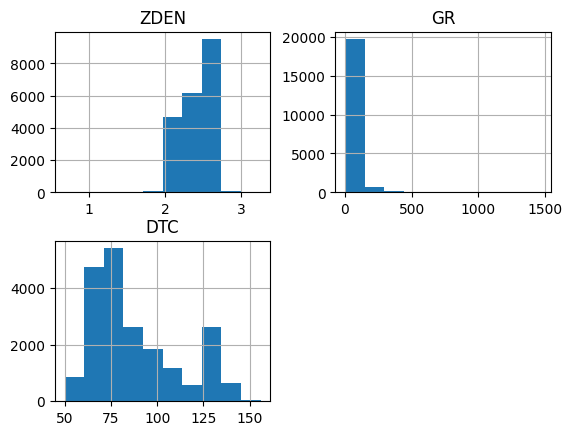

In [37]:
three_hist = three.hist()

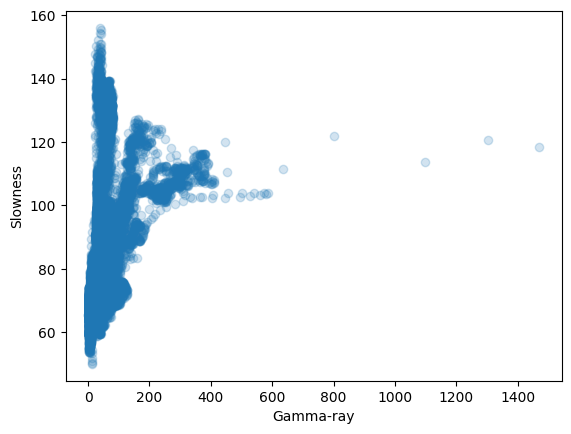

In [38]:
# display scatter plot

import matplotlib.pyplot as plt
plt.scatter(three.GR, three.DTC, alpha=0.2)
plt.xlabel('Gamma-ray')
plt.ylabel('Slowness')
plt.show()

In [39]:
# remove anomalous density values and anomalous gamma-ray values
three2=three.loc[(three.ZDEN > 1.5) & (three.ZDEN < 3.1) &
                 (three.GR < 400)]
three2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20481 entries, 573 to 30142
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    20481 non-null  float64
 1   GR      20481 non-null  float64
 2   DTC     20481 non-null  float64
dtypes: float64(3)
memory usage: 640.0 KB


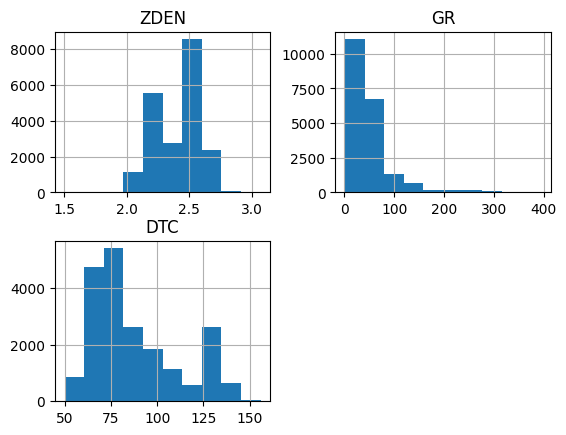

In [40]:
three2_hist = three2.hist()

In [41]:
# divide into training and testing
select3 = np.random.rand(len(three2)) < 0.8
train3 = three2[select3]
test3 = three2[~select3]

train3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16358 entries, 574 to 30142
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ZDEN    16358 non-null  float64
 1   GR      16358 non-null  float64
 2   DTC     16358 non-null  float64
dtypes: float64(3)
memory usage: 511.2 KB


In [42]:
# create model
model3 = linear_model.LinearRegression()

# train model
model3.fit(train3[['ZDEN', 'GR']], train3['DTC'])

LinearRegression()

In [43]:
# regression coefficients
print('Intercept: ', model3.intercept_)
print('Coefficients: ', model3.coef_)

Intercept:  323.972412409137
Coefficients:  [-100.06323893    0.11209278]


The model changes from
$$s(\rho) = a + b\,\rho$$
to
$$s(\rho,\gamma) = a + b\,\rho + c\,\gamma$$

and also involves three parameters ($a,b,c$) instead of two ($a,b$).

It represents a plane in the three-dimensional space instead of a line in the two-dimensional space.

In [44]:
want3 = test3['DTC']
get3 = model3.predict(test3[['ZDEN', 'GR']])

print("RMS error: %.3f" % root_mean_squared_error(get3, want3))

RMS error: 12.770


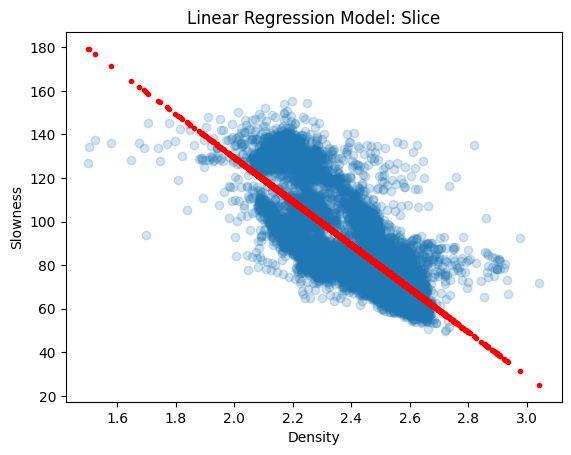

In [45]:
plt.scatter(train3.ZDEN, train3.DTC, alpha=0.2)
plt.plot(train3.ZDEN, model3.intercept_ +
         train3.ZDEN * model3.coef_[0] +
         np.mean(train3.GR) * model3.coef_[1], '.r')
plt.title('Linear Regression Model: Slice')
plt.xlabel('Density')
plt.ylabel('Slowness')
plt.show()

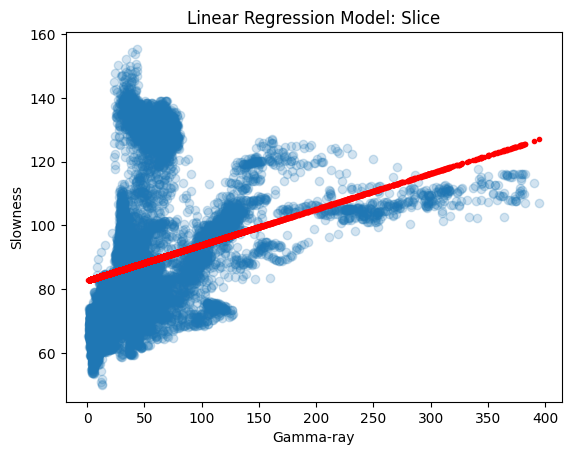

In [46]:
plt.scatter(train3.GR, train3.DTC, alpha=0.2)
plt.plot(train3.GR, model3.intercept_ +
         np.mean(train3.ZDEN) * model3.coef_[0] +
         train3.GR * model3.coef_[1], '.r')
plt.title('Linear Regression Model: Slice')
plt.xlabel('Gamma-ray')
plt.ylabel('Slowness')
plt.show()

In [47]:
D = np.linspace(np.min(train3.ZDEN), np.max(train3.ZDEN), 10)
G = np.linspace(np.min(train3.GR), np.max(train3.GR), 10)
D, G = np.meshgrid(D, G)
S = model3.intercept_ + D * model3.coef_[0] + G * model3.coef_[1]

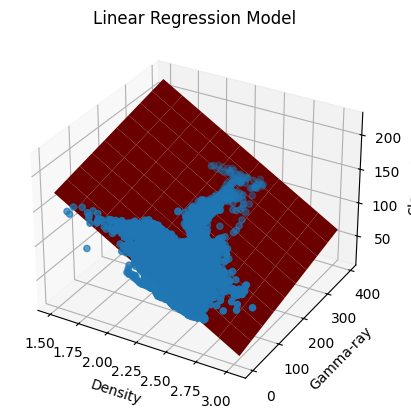

In [48]:
axes = plt.axes(projection='3d')
axes.scatter(train3.ZDEN, train3.GR, train3.DTC)
axes.plot_surface(D, G, S, color='r')
plt.title('Linear Regression Model')
axes.set_xlabel('Density')
axes.set_ylabel('Gamma-ray')
axes.set_zlabel('Slowness')
plt.show()

## Task 2

<div class="alert alert-block alert-info">
Can you improve the fit further by using more logs for prediction in addition to density and gamma-ray?

$$s(l_1,l_2,\cdots,l_N) = a_0 + b_1\,l_1 + b_2\,l_2  + \cdots + b_N\,l_N$$

Choose $N \ge 3$ and add code to try it out.

The suitable logs are neutron, gamma ray, deep resistance, medium resistance, photo-electric factor, and density.</div>

In [49]:
# select three logs
more = logs.loc[:, ['CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN', 'DTC']]
# data information
more.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20525 entries, 573 to 30142
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CNC     20525 non-null  float64
 1   GR      20525 non-null  float64
 2   HRD     20525 non-null  float64
 3   HRM     20525 non-null  float64
 4   PE      20525 non-null  float64
 5   ZDEN    20525 non-null  float64
 6   DTC     20525 non-null  float64
dtypes: float64(7)
memory usage: 1.3 MB


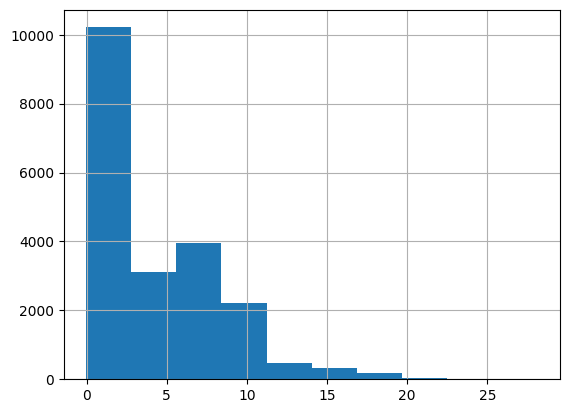

In [50]:
more_hist = more['PE'].hist()


In [51]:
fitered_more = more.loc[(more.ZDEN > 1.5) & (more.ZDEN < 3.1) &
                 (more.GR < 400) &
                        (more.CNC < 50) & (more.HRD < 50) & (more.HRM < 10000)
                        & (more.PE < 25)]
fitered_more.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20450 entries, 576 to 30142
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CNC     20450 non-null  float64
 1   GR      20450 non-null  float64
 2   HRD     20450 non-null  float64
 3   HRM     20450 non-null  float64
 4   PE      20450 non-null  float64
 5   ZDEN    20450 non-null  float64
 6   DTC     20450 non-null  float64
dtypes: float64(7)
memory usage: 1.2 MB


In [52]:
# divide into training and testing
select_task2 = np.random.rand(len(more)) < 0.8
train_task2 = more[select_task2 ]
test_task2 = more[~select_task2 ]

train_task2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16283 entries, 573 to 30142
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CNC     16283 non-null  float64
 1   GR      16283 non-null  float64
 2   HRD     16283 non-null  float64
 3   HRM     16283 non-null  float64
 4   PE      16283 non-null  float64
 5   ZDEN    16283 non-null  float64
 6   DTC     16283 non-null  float64
dtypes: float64(7)
memory usage: 1017.7 KB


In [53]:
model_task2 = linear_model.LinearRegression()

# train model
model_task2.fit(train_task2[['CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']], train_task2['DTC'])

LinearRegression()

In [54]:
want = test_task2['DTC']

get = model_task2.predict(test_task2[['CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']])

print("RMS error: %.3f" % root_mean_squared_error(get, want))

RMS error: 11.408


## Conclusions

Simple linear regression is too primitive to be of practical use in this case.

However, it illustrates the general principles of supervised learning:

1. Our goal is to predict one part of the data from the other parts.
2. To make a prediction, we build a model which depends on parameters.
3. The parameters are estimated from training data by minimizing an objection function, which measures the prediction error.
4. Minimization generally involves a form of gradient descent (*analytical in the case of linear regression*.)
5. We can set aside part of the available data and use it for validation.
6. There are uncertainties in the parameter estimation and the model prediction.

## Bonus Task 3

<div class="alert alert-block alert-info">
Continue using the Linear Regression approach but try to improve the results by non-linear transformations of the dependent variables. The task is open-ended, but here are some possibilities to explore:</div>

1. Try predicting velocity (1/slowness) instead of slowness.

2. [Gardner's equation](https://wiki.seg.org/wiki/Dictionary:Gardner%E2%80%99s_equation) suggests an empirical relationship between density and velocity of the form

$$\rho = \alpha\,v^{\beta}\;,$$

where the parameters $\alpha$ and $\beta$ depend on lithology.

Taking the logarithm of both sides,

$$\log \rho = \log{\alpha} + \beta\,\log{v}\ = \log{\alpha} - \beta\,\log{s}\;.$$

This relationship suggests switching to logarithms in the linear regression model.

3. Try other non-linear functions of logs in addition to multiple logs as independent variables in linear regression.

In [55]:
train_task3 = train_task2.assign(vel=1/(train_task2.DTC))
test_task3 = test_task2.assign(vel=1/(test_task2.DTC))
# train_task2['vel'] = np.power(train_task2.DTC, -1)
# test_task2['vel'] = np.power(test_task2.DTC, -1)

train_task3.head()

,CNC,GR,HRD,HRM,PE,ZDEN,DTC,vel
573,0.5173,57.1903,1.9826,1.9726,27.9432,2.3510,125.9611,0.007939
574,0.4966,63.1593,2.0472,1.6373,28.1064,2.4055,125.9726,0.007938
575,0.4433,64.5217,2.0464,1.4866,26.5968,2.4579,125.8528,0.007946
576,0.4309,63.0144,2.0054,1.4613,19.5635,2.4219,125.7362,0.007953
577,0.4469,60.8421,1.9533,1.4438,9.8556,2.3138,125.9774,0.007938


In [56]:
1/125.9611

0.007938958932559338

In [57]:
model_task3 = linear_model.LinearRegression()

# train model
model_task3.fit(train_task3[['CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']], train_task3['vel'])

LinearRegression()

In [58]:
want = test_task3['vel']

get = model_task3.predict(test_task3[['CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']])

print("RMS error: %.3f" % root_mean_squared_error(get, want))

RMS error: 0.001


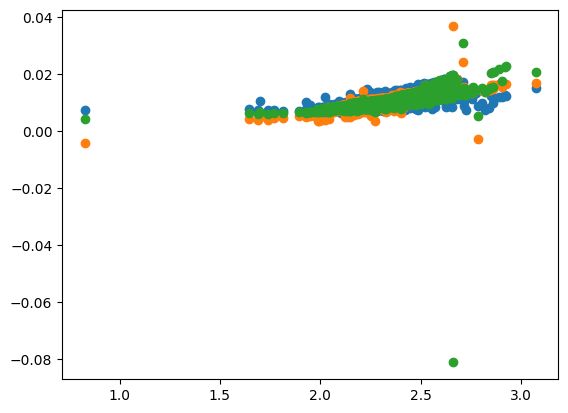

In [67]:
plt.plot(test_task3.ZDEN, want, 'o')
plt.plot(test_task3.ZDEN, get, 'o')
plt.plot(test_task3.ZDEN, 1/model_task2.predict(
    test_task2[['CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']]), 'o')

In [70]:
root_mean_squared_error(1/want, 1/get)

16.6628407675957

In [69]:
root_mean_squared_error(want, 1/model_task2.predict(
    test_task2[['CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']]))

0.0020832424697618673